In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.utils import shuffle

# Load Data

In [2]:
# Training and testing data directories
train_dir = os.path.expanduser('~/Desktop/Projects/Brain Tumor Detection/brain_data/Training')
test_dir = os.path.expanduser('~/Desktop/Projects/Brain Tumor Detection/brain_data/Testing')

# Load and shuffle the training data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the testing data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

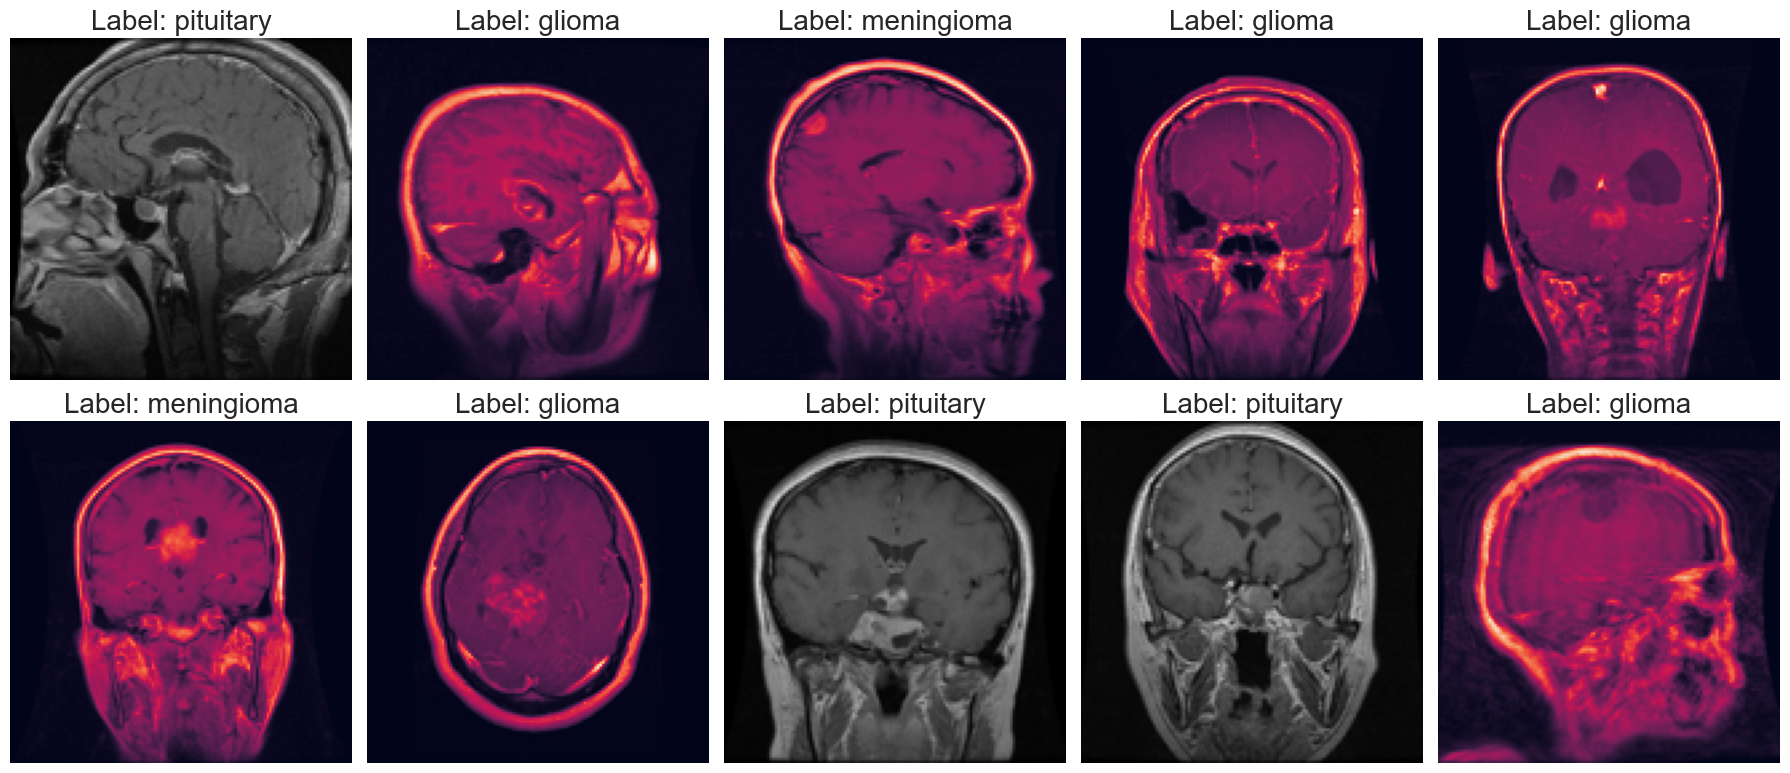

In [3]:
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(train_paths)), 10)
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.ravel()

# Display images randomized from sample
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128, 128))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=20)

plt.tight_layout()
plt.show()

# Preprocessing

In [42]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Convert labels to ints
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# Model

In [44]:
# Model architecture
IMAGE_SIZE = 224

# Load MobileNetV3Large as base model
base_model = MobileNetV3Large(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling=None,
    include_preprocessing=False
)

# Freeze all layers of the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Set the last 20 layers to be trainable
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))

# Dense layer with ReLU activation
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 50

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - loss: 0.7299 - sparse_categorical_accuracy: 0.7988
Epoch 2/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9718
Epoch 3/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9898
Epoch 4/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 35s 122ms/step - loss: 0.0218 - sparse_categorical_accuracy: 0.9915
Epoch 5/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - loss: 0.0122 - sparse_categorical_accuracy: 0.9955
Epoch 6/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - loss: 0.0129 - sparse_categorical_accuracy: 0.9949
Epoch 7/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - loss: 0.0078 - sparse_categorical_accuracy: 0.9981
Epoch 8/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 125ms/step - loss: 0.0086 - sparse_categorical_accuracy: 0.9963
Epoch 9/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 125ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9962
Epoch 10/50
285/285 ━━━━━━━━

# Training Plot

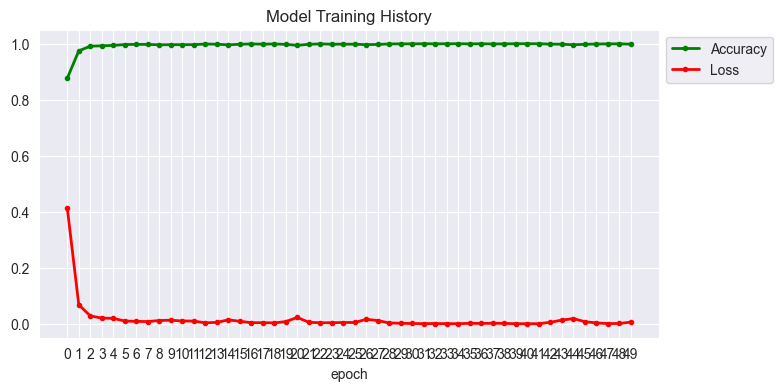

In [45]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Classification Report

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict on test data using the trained model
test_predictions = model.predict(test_images)

# Classification Report
print("Classification Report:")
print(classification_report(
    test_labels_encoded,
    np.argmax(test_predictions, axis=1),
    digits=4
))

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.9739    0.9967    0.9852       300
           1     0.9975    1.0000    0.9988       405
           2     0.9829    0.9567    0.9696       300
           3     0.9575    0.9575    0.9575       306

    accuracy                         0.9794      1311
   macro avg     0.9780    0.9777    0.9778      1311
weighted avg     0.9794    0.9794    0.9794      1311



# Confusion Matrix

Confusion Matrix:
[[299   0   0   1]
 [  0 405   0   0]
 [  1   0 287  12]
 [  7   1   5 293]]


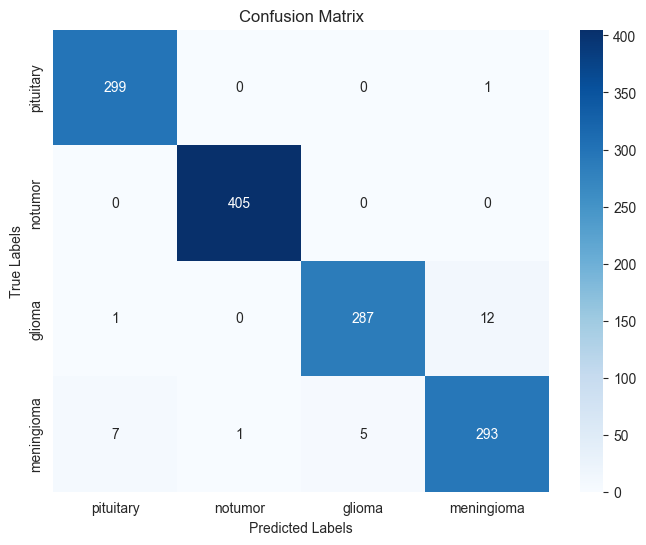

In [47]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC Curve

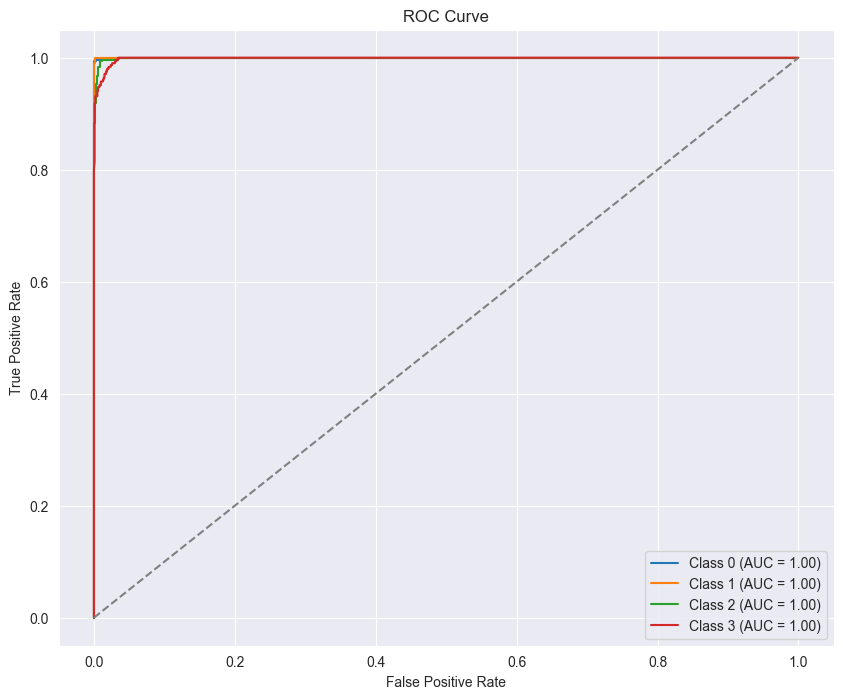

In [48]:
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save & Load Model

In [49]:
model.save('model.keras')

In [81]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.keras')

# Tumor Detection System

In [82]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'notumor', 'glioma', 'meningioma']

def detect_and_display(img_path, model, image_size=224):  # Changed default to 224
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))  # Now 224x224
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


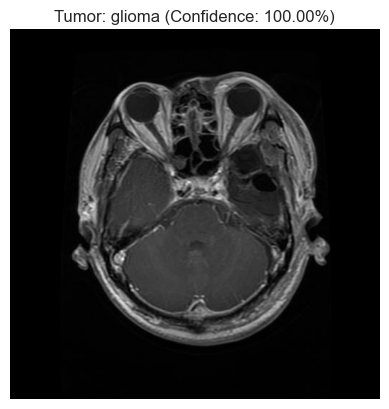

In [85]:
# Test case for glioma
image_path = os.path.expanduser('~/Desktop/Projects/Brain Tumor Detection/Te-gl_0011.jpg')
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


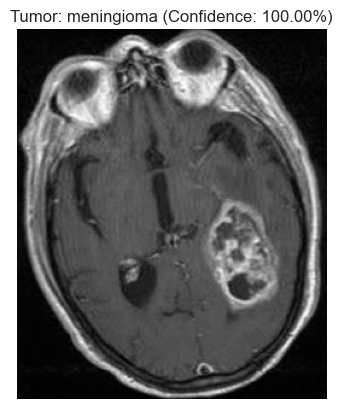

In [86]:
# Test Case for meningioma
image_path = os.path.expanduser('~/Desktop/Projects/Brain Tumor Detection/Te-meTr_0001.jpg')
detect_and_display(image_path, model)